In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon, Point
import geopandas as gpd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from tqdm import tqdm  # Optional: For progress tracking
from scipy.interpolate import griddata
import os

# Load Data (From NetCDF Files)

## Load Monthly Historical Deviations

In [3]:
historical_deviations = xr.open_dataset(r'../datasets/era5/historical_deviations.nc')
historical_deviations = historical_deviations.to_dataframe()
historical_deviations = historical_deviations.droplevel('expver')
#historical_deviations_q = pd.read_excel(r'../../database/historical_deviations_y.xlsx') 
historical_deviations_q = xr.open_dataset(r'../datasets/era5/historical_deviations_qaurt.nc') #
historical_deviations_q = historical_deviations_q.to_dataframe()
# historical_deviations_q = historical_deviations_q.drop(columns=['Unnamed: 0'])
# historical_deviations_q = historical_deviations_q.set_index(['longitude', 'latitude', 'time'])
historical_deviations_q #= historical_deviations_q.reset_index()

t2m         msl       sst       stl2  \
longitude latitude  time                                                 
-9.50     36.919998 1990Q1  -1.788788  687.804688 -1.552887  -1.549072   
                    1990Q2   0.171722  -82.000000 -0.164520  -0.181946   
                    1990Q3   4.029266  -64.945312  3.402679   3.388184   
                    1990Q4   0.222076    3.695312  1.018066   1.049500   
                    1991Q1  -3.025543  136.156250 -2.493286  -2.487122   
...                               ...         ...       ...        ...   
-6.25     41.919998 2021Q4  -2.316956  258.023438       NaN  -1.933746   
                    2022Q1  -4.707794  664.765625       NaN  -5.265533   
                    2022Q2   4.522705 -142.835938       NaN   4.583618   
                    2022Q3  10.914612 -169.976562       NaN  12.211090   
                    2022Q4  -0.627441  -14.710938       NaN  -0.199432   

                                    sp        tp   tp_1000  
longitude latitude  time                                    
-9.50     36.919998 1990Q1  688.023438  0.000742  0.742284  
                    1990Q2  -82.125000 -0.000698 -0.698230  
                    1990Q3  -64.914062 -0.001257 -1.256968  
                    1990Q4    3.914062  0.001354  1.354294  
                    1991Q1  136.257812  0.001011  1.010503  
...                                ...       ...       ...  
-6.25     41.919998 2021Q4  210.429688 -0.000182 -0.182273  
                    2022Q1  511.179688 -0.000483 -0.483322  
                    2022Q2  -37.062500 -0.000442 -0.442439  
                    2022Q3   63.265625 -0.001064 -1.063895  
                    2022Q4   -7.812500  0.001788  1.788020  

[38808 rows x 7 columns]

## Load Intra-Monthly Standard Deviations

In [4]:
erA5_std_df = xr.open_dataset(r'../datasets/era5/std_ds.nc')
erA5_std_df = erA5_std_df.to_dataframe()
#erA5_std_df_q =pd.read_excel(r'../../database/std_ds_yearly.xlsx') 
erA5_std_df_q = xr.open_dataset(r'../datasets/era5/std_ds_qaurt.nc') # xr.open_dataset(r'../../database/std_ds_yearly.nc' 
erA5_std_df_q = erA5_std_df_q.to_dataframe()
# erA5_std_df_q = erA5_std_df_q.drop(columns=['Unnamed: 0'])
# erA5_std_df_q = erA5_std_df_q.set_index(['longitude', 'latitude', 'time'])
erA5_std_df_q #= erA5_std_df_q.reset_index()

t2m         msl      stl2            sp  \
longitude latitude  time                                                   
-9.50     36.919998 1990Q1  0.756860  507.999847  0.226817  50801.234375   
                    1990Q2  0.653594  404.153412  0.391271  40417.656250   
                    1990Q3  0.745086  213.085373  0.501232  21310.359375   
                    1990Q4  1.275766  503.008453  0.574224  50301.730469   
                    1991Q1  1.034864  682.493652  0.196970  68251.132812   
...                              ...         ...       ...           ...   
-6.25     41.919998 2021Q4  1.988830  545.181458  1.447435  50493.031250   
                    2022Q1  2.174918  435.529877  1.686890  39931.597656   
                    2022Q2  3.814677  440.553864  2.755682  42369.257812   
                    2022Q3  2.880835  283.507111  2.234593  25364.177734   
                    2022Q4  2.398964  603.123840  1.834869  56118.792969   

                                  tp   tp_1000  
longitude latitude  time                        
-9.50     36.919998 1990Q1  0.000187  0.187188  
                    1990Q2  0.000058  0.058469  
                    1990Q3  0.000004  0.003909  
                    1990Q4  0.000183  0.183243  
                    1991Q1  0.000179  0.179103  
...                              ...       ...  
-6.25     41.919998 2021Q4  0.000123  0.123433  
                    2022Q1  0.000073  0.073093  
                    2022Q2  0.000096  0.095622  
                    2022Q3  0.000059  0.058504  
                    2022Q4  0.000190  0.189585  

[38808 rows x 6 columns]

#### Save Excel For Paulo

In [95]:
# erA5_std_df_q.to_excel(r'../../database/std_ds_yearly.xlsx')
# historical_deviations_q.to_excel(r'../../database/historical_deviations_y.xlsx')

## Load Municipality Data

In [7]:
mun_gdf = gpd.read_file(r'../datasets/municipality_data/municipalities-shapefile-2/concelhos.shp')
mun_metadata  = pd.read_excel(r'../datasets/municipality_data/concelhos-metadata.xlsx', dtype={'dicofre' : 'string'})
mun_metadata = mun_metadata[['dicofre','designacao']]
mun_gdf = mun_gdf.merge(mun_metadata, left_on='CCA_2', right_on='dicofre').drop(columns='NAME_2')
mun_gdf = mun_gdf.rename(columns={'designacao': 'NAME_2'})

In [8]:
nuts_gdf = gpd.read_file(r'../datasets/municipality_data/NUTS_RG_10M_2021_4326.shp/NUTS_RG_10M_2021_4326.shp')
nuts_gdf = nuts_gdf[nuts_gdf['CNTR_CODE'].isin(['PT'])]
nuts_gdf = nuts_gdf[nuts_gdf['LEVL_CODE'].isin([2])]
nuts_gdf_mainland = nuts_gdf[~nuts_gdf['NUTS_NAME'].isin(['Região Autónoma dos Açores', 'Região Autónoma da Madeira'])]

## Debugging For the NUTS!
- Lets try some assert statements to check if we are procceeding correctly 
- If the code below runs with no output, then we are correct!
- If not, we will get an `AssertionError`
- **REPLACE THE TIME STRING WITH THE PERIODICITY OF YOUR DATA I.E 1990-01, 1990Q1 OR 1990 BASED ON MMYYYY/YYYYMM, YYYYQQ OR YYYY**

In [11]:
# assert '1990' in historical_deviations_q.reset_index()['time'].unique()
# assert '1990' in erA5_std_df_q.reset_index()['time'].unique()

# Polygons

## Define Polygon Class

In [12]:
class PolygonConversion:
    @staticmethod
    def fetch_geo_polygon(latitude: float, longitude: float, lat_grid_resolution: float, lon_grid_resolution: float) -> Polygon:
        """Create a Polygon based on latitude, longitude, and resolution.

        Example ::
            * - . - *
            |       |
            .   •   .
            |       |
            * - . - *
        In order to create the polygon, we require the `*` point as indicated in the above example.
        To determine the position of the `*` point, we find the `.` point.
        The `get_lat_lon_range` function gives the `.` point and `bound_point` gives the `*` point.
            """        # Calculate the half-size of the bounding box
        half_size_lon = lon_grid_resolution / 2
        half_size_lat = lat_grid_resolution / 2
        
        # Calculate the bound points
        lower_left = (longitude - half_size_lon, latitude - half_size_lat)
        upper_left = (longitude - half_size_lon, latitude + half_size_lat)
        upper_right = (longitude + half_size_lon, latitude + half_size_lat)
        lower_right = (longitude + half_size_lon, latitude - half_size_lat)
        
        polygon = Polygon([lower_left, upper_left, upper_right, lower_right])
        return polygon



## Creating Points from Lat,and Lon and Polygons centered on Points

### Historical Deviations

In [13]:
polygon_converter = PolygonConversion()

# Assume your dataset is named 'ds' (replace it with the actual name)
# Accessing latitude and longitude from the dataset
lats = historical_deviations.index.get_level_values('latitude').values
lons = historical_deviations.index.get_level_values('longitude').values

# Spatial resolution of your data
lat_resolution = 0.25
lon_resolution = 0.25

# Create a DataFrame to store latitudes and longitudes
df_points = pd.DataFrame({
    'lat': lats,
    'lon': lons
})

geometry = [Point(lon, lat) for lon, lat in zip(lons, lats)]
gdf_points = gpd.GeoDataFrame(geometry = geometry, crs="EPSG:4326", index=historical_deviations.index)
gdf_points.rename(columns = {'geometry' : 'points_geometry'}, inplace = True)
# Create a GeoDataFrame with Polygon geometries
polygons = []
for _, row in tqdm(df_points.iterrows(), total=len(df_points), desc="Creating Polygons"):
    lat, lon = row['lat'], row['lon']
    polygon = polygon_converter.fetch_geo_polygon(lat, lon, lat_resolution, lon_resolution)
    polygons.append(polygon)

# Create a GeoDataFrame with the constructed polygons
gdf_polygons = gpd.GeoDataFrame(geometry=polygons, crs="EPSG:4326")
gdf_polygons = gdf_polygons.set_index(historical_deviations.index)

Creating Polygons: 100%|██████████| 116424/116424 [00:02<00:00, 43315.56it/s]


#### Quarterly Data

In [14]:
polygon_converter = PolygonConversion()

# Assume your dataset is named 'ds' (replace it with the actual name)
# Accessing latitude and longitude from the dataset
lats_q = historical_deviations_q.index.get_level_values('latitude').values
lons_q = historical_deviations_q.index.get_level_values('longitude').values

# Spatial resolution of your data
lat_resolution_q = 0.25
lon_resolution_q = 0.25

# Create a DataFrame to store latitudes and longitudes
df_points_q = pd.DataFrame({
    'lat': lats_q,
    'lon': lons_q
})

geometry_q = [Point(lon_q, lat_q) for lon_q, lat_q in zip(lons_q, lats_q)]
gdf_points_q = gpd.GeoDataFrame(geometry = geometry_q, crs="EPSG:4326", index=historical_deviations_q.index)
gdf_points_q.rename(columns = {'geometry' : 'points_geometry'}, inplace = True)
# Create a GeoDataFrame with Polygon geometries
polygons_q = []
for _, row in tqdm(df_points_q.iterrows(), total=len(df_points_q), desc="Creating Polygons"):
    lat_q, lon_q = row['lat'], row['lon']
    polygon_q = polygon_converter.fetch_geo_polygon(lat_q, lon_q, lat_resolution_q, lon_resolution_q)
    polygons_q.append(polygon_q)

# Create a GeoDataFrame with the constructed polygons
gdf_polygons_q = gpd.GeoDataFrame(geometry=polygons_q, crs="EPSG:4326")
gdf_polygons_q = gdf_polygons_q.set_index(historical_deviations_q.index)

Creating Polygons: 100%|██████████| 38808/38808 [00:00<00:00, 42710.92it/s]


### Standard Deviations

In [15]:
polygon_converter = PolygonConversion()

# Assume your dataset is named 'ds' (replace it with the actual name)
# Accessing latitude and longitude from the dataset
lats_std = erA5_std_df.index.get_level_values('latitude').values
lons_std = erA5_std_df.index.get_level_values('longitude').values

# Spatial resolution of your data
lat_resolution = 0.25
lon_resolution = 0.25

# Create a DataFrame to store latitudes and longitudes
df_points_std = pd.DataFrame({
    'lat': lats_std,
    'lon': lons_std
})
geometry_std = [Point(lon, lat) for lon, lat in zip(lons_std, lats_std)]
gdf_points_std = gpd.GeoDataFrame(geometry = geometry_std, crs="EPSG:4326", index=erA5_std_df.index)
gdf_points_std.rename(columns = {'geometry' : 'points_geometry'}, inplace = True)

# Create a GeoDataFrame with Polygon geometries
polygons_std = []
for _, row in tqdm(df_points_std.iterrows(), total=len(df_points_std), desc="Creating Polygons"):
    lat, lon = row['lat'], row['lon']
    polygon = polygon_converter.fetch_geo_polygon(lat, lon, lat_resolution, lon_resolution)
    polygons_std.append(polygon)

# Create a GeoDataFrame with the constructed polygons
gdf_polygons_std = gpd.GeoDataFrame(geometry=polygons_std, crs="EPSG:4326")
gdf_polygons_std = gdf_polygons_std.set_index(erA5_std_df.index)

Creating Polygons: 100%|██████████| 116424/116424 [00:02<00:00, 42843.53it/s]


#### Quarterly Data

In [16]:
polygon_converter = PolygonConversion()

# Assume your dataset is named 'ds' (replace it with the actual name)
# Accessing latitude and longitude from the dataset
lats_std_q = erA5_std_df_q.index.get_level_values('latitude').values
lons_std_q = erA5_std_df_q.index.get_level_values('longitude').values

# Spatial resolution of your data
lat_resolution_q = 0.25
lon_resolution_q = 0.25

# Create a DataFrame to store latitudes and longitudes
df_points_std_q = pd.DataFrame({
    'lat': lats_std_q,
    'lon': lons_std_q
})
geometry_std_q = [Point(lon_q, lat_q) for lon_q, lat_q in zip(lons_std_q, lats_std_q)]
gdf_points_std_q = gpd.GeoDataFrame(geometry = geometry_std_q, crs="EPSG:4326", index=erA5_std_df_q.index)
gdf_points_std_q.rename(columns = {'geometry' : 'points_geometry'}, inplace = True)

# Create a GeoDataFrame with Polygon geometries
polygons_std_q = []
for _, row in tqdm(df_points_std_q.iterrows(), total=len(df_points_std_q), desc="Creating Polygons"):
    lat_q, lon_q = row['lat'], row['lon']
    polygon_q = polygon_converter.fetch_geo_polygon(lat_q, lon_q, lat_resolution_q, lon_resolution_q)
    polygons_std_q.append(polygon_q)

# Create a GeoDataFrame with the constructed polygons
gdf_polygons_std_q = gpd.GeoDataFrame(geometry=polygons_std_q, crs="EPSG:4326")
gdf_polygons_std_q = gdf_polygons_std_q.set_index(erA5_std_df_q.index)

Creating Polygons: 100%|██████████| 38808/38808 [00:00<00:00, 39812.85it/s]


## Debugging For the NUTS!
- Lets try some assert statements to check if we are procceeding correctly 
- If the code below runs with no output, then we are correct!
- If not, we will get an `AssertionError`

In [82]:
# assert '1990' in gdf_polygons_q.reset_index()['time'].unique()
# assert '1990' in gdf_polygons_std_q.reset_index()['time'].unique()

## Merging Polygons with Renalysis Data

### Historical Deviations

In [17]:

# Extract latitude and longitude from the MultiIndex DataFrame
latitudes = historical_deviations.index.get_level_values('latitude').values
longitudes = historical_deviations.index.get_level_values('longitude').values


# Merge the GeoDataFrame into the MultiIndex DataFrame
merged_df = pd.concat([historical_deviations, gdf_points, gdf_polygons], axis=1)


#### Quarterly Data

In [18]:

# Extract latitude and longitude from the MultiIndex DataFrame
latitudes_q = historical_deviations_q.index.get_level_values('latitude').values
longitudes_q = historical_deviations_q.index.get_level_values('longitude').values


# Merge the GeoDataFrame into the MultiIndex DataFrame
merged_df_q = pd.concat([historical_deviations_q, gdf_points_q, gdf_polygons_q], axis=1)


In [117]:
merged_df_q.head()

t2m         msl       sst      stl2  \
longitude latitude  time                                               
-9.5      36.919998 1990Q1 -1.788788  687.804688 -1.552887 -1.549072   
                    1990Q2  0.171722  -82.000000 -0.164520 -0.181946   
                    1990Q3  4.029266  -64.945312  3.402679  3.388184   
                    1990Q4  0.222076    3.695312  1.018066  1.049500   
                    1991Q1 -3.025543  136.156250 -2.493286 -2.487122   

                                    sp        tp   tp_1000  \
longitude latitude  time                                     
-9.5      36.919998 1990Q1  688.023438  0.000742  0.742284   
                    1990Q2  -82.125000 -0.000698 -0.698230   
                    1990Q3  -64.914062 -0.001257 -1.256968   
                    1990Q4    3.914062  0.001354  1.354294   
                    1991Q1  136.257812  0.001011  1.010503   

                                      points_geometry  \
longitude latitude  time                                
-9.5      36.919998 1990Q1  POINT (-9.50000 36.92000)   
                    1990Q2  POINT (-9.50000 36.92000)   
                    1990Q3  POINT (-9.50000 36.92000)   
                    1990Q4  POINT (-9.50000 36.92000)   
                    1991Q1  POINT (-9.50000 36.92000)   

                                                                     geometry  
longitude latitude  time                                                       
-9.5      36.919998 1990Q1  POLYGON ((-9.62500 36.79500, -9.62500 37.04500...  
                    1990Q2  POLYGON ((-9.62500 36.79500, -9.62500 37.04500...  
                    1990Q3  POLYGON ((-9.62500 36.79500, -9.62500 37.04500...  
                    1990Q4  POLYGON ((-9.62500 36.79500, -9.62500 37.04500...  
                    1991Q1  POLYGON ((-9.62500 36.79500, -9.62500 37.04500...

### Standard Deviations

In [19]:

# Extract latitude and longitude from the MultiIndex DataFrame
latitudes_std = erA5_std_df.index.get_level_values('latitude').values
longitudes_std = erA5_std_df.index.get_level_values('longitude').values


# Merge the GeoDataFrame into the MultiIndex DataFrame
merged_std_df = pd.concat([erA5_std_df, gdf_points_std, gdf_polygons_std], axis=1)


#### Quarterly Data

In [20]:

# Extract latitude and longitude from the MultiIndex DataFrame
latitudes_std_q = erA5_std_df_q.index.get_level_values('latitude').values
longitudes_std_q = erA5_std_df_q.index.get_level_values('longitude').values


# Merge the GeoDataFrame into the MultiIndex DataFrame
merged_std_df_q = pd.concat([erA5_std_df_q, gdf_points_std_q, gdf_polygons_std_q], axis=1)


# Plotting

In [22]:
filtered_df = merged_std_df[merged_std_df.index.get_level_values('time') == '2020-06-01']
#filtered_df = filtered_df.dropna(subset = ['tp'])
# Compute the mean over the step dimension as well
longitudes = filtered_df.index.get_level_values('longitude').values
latitudes = filtered_df.index.get_level_values('latitude').values
values = filtered_df['tp'].values
filtered_df = gpd.GeoDataFrame(filtered_df, crs='EPSG:4326')

## Visualising Polygons, Points and Municipalities

In [23]:
gdf_points_q.set_geometry('points_geometry', inplace=True)
mainland = mun_gdf[~mun_gdf['NAME_1'].isin(['Azores', 'Madeira'])]

# Grouping and dissolving the municipalities by district
districts_gdf = mainland.dissolve(by='NAME_1', as_index=False)
districts_gdf = districts_gdf[['NAME_1', 'HASC_2', 'geometry']]
municipalities_mainland = mainland[['NAME_1', 'HASC_2', 'geometry']]

### Visualising NUTS2

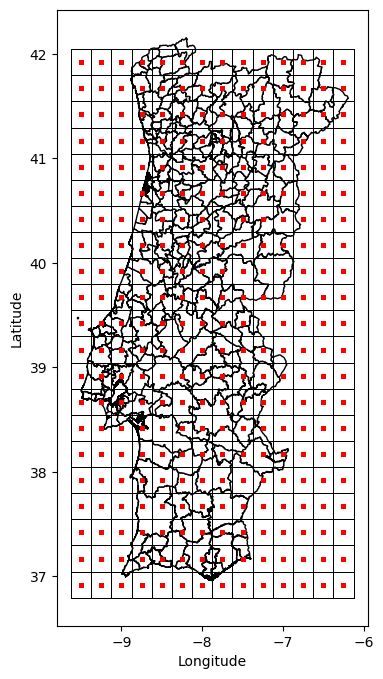

In [27]:

# Plot the polygons
fig, ax = plt.subplots(figsize=(12, 8))
gdf_polygons_q.boundary.plot(ax=ax, color='black', linewidth=0.5)




# 'districts_gdf' now contains combined geometries for each district

#mainland.plot(ax=ax, color='white', edgecolor='black')  # Adjust colors as needed
#districts_gdf.plot(ax=ax, color='white', edgecolor='black')
mainland.plot(ax=ax, color='white', edgecolor='black')
# Overlaying the points
gdf_points_q.plot(ax=ax, marker='o', color='red', markersize=5)  # Adjust marker style as needed

#plt.title('Polygons Based on Dataset Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


# # Adding titles and labels (optional)
# ax.set_title('Municipalities and Points')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')

# plt.show()


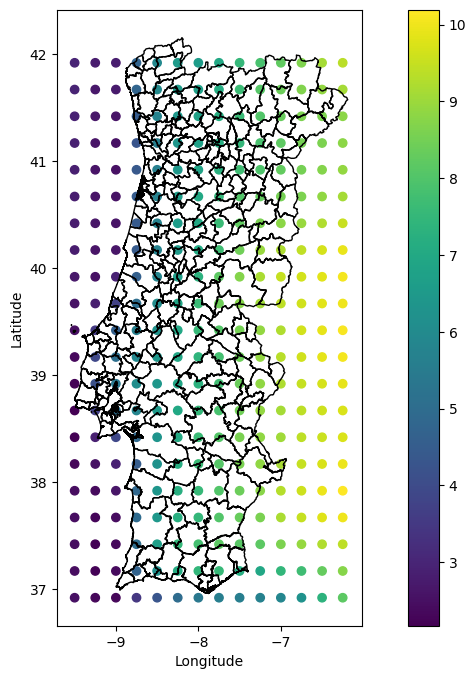

In [61]:
merged_df_q_points = merged_df_q.drop(columns = ['geometry'])
merged_df_q_points = merged_df_q_points.rename(columns = {'points_geometry' : 'geometry'})
merged_df_q_points = gpd.GeoDataFrame(merged_df_q_points)
filtered_df = merged_df_q_points[merged_df_q_points.index.get_level_values('time') == '2017Q3']
#filtered_df = filtered_df.dropna(subset = ['tp'])
# Compute the mean over the step dimension as well
longitudes = filtered_df.index.get_level_values('longitude').values
latitudes = filtered_df.index.get_level_values('latitude').values
values = filtered_df['tp'].values
filtered_df = gpd.GeoDataFrame(filtered_df, crs='EPSG:4326')


fig, ax = plt.subplots(figsize=(12, 8))
mainland = mun_gdf[~mun_gdf['NAME_1'].isin(['Azores', 'Madeira'])]
filtered_df.plot(column='t2m', kind = 'geo',cmap='viridis', legend=True, ax=ax)
mainland.plot(ax=ax, facecolor="none", edgecolor='black')  # Adjust colors as needed

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

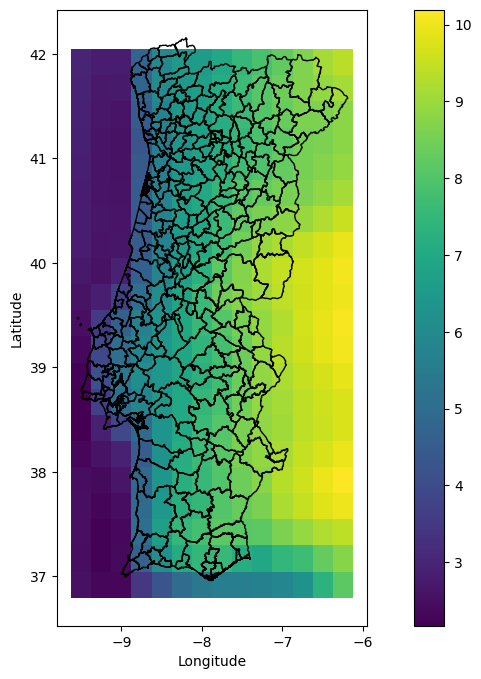

In [62]:
filtered_df = merged_df_q[merged_df_q.index.get_level_values('time') == '2017Q3']
#filtered_df = filtered_df.dropna(subset = ['tp'])
# Compute the mean over the step dimension as well
longitudes = filtered_df.index.get_level_values('longitude').values
latitudes = filtered_df.index.get_level_values('latitude').values
values = filtered_df['tp'].values
filtered_df = gpd.GeoDataFrame(filtered_df, crs='EPSG:4326')


fig, ax = plt.subplots(figsize=(12, 8))
mainland = mun_gdf[~mun_gdf['NAME_1'].isin(['Azores', 'Madeira'])]
filtered_df.plot(column='t2m', kind = 'geo',cmap='viridis', legend=True, ax=ax)
mainland.plot(ax=ax, facecolor="none", edgecolor='black')  # Adjust colors as needed

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

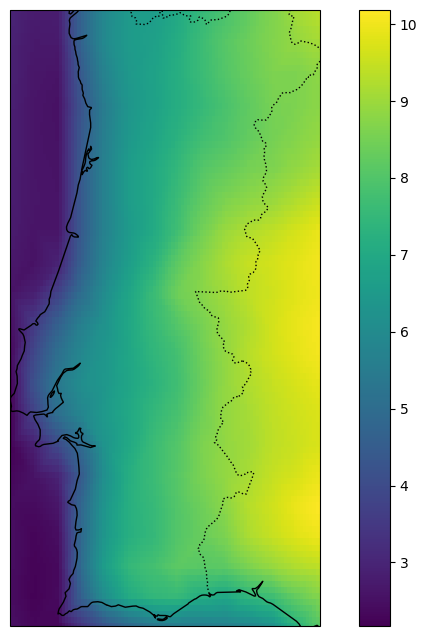

In [52]:
fig, grid_data = plot_interpolated_map(historical_deviations_q, '2017Q3', 't2m', title = False)
fig.xlabel('Longitude')
fig.ylabel('Latitude')
fig.show()

# Merging Districts and Era5

## Obtain Districts for Portugal

In [24]:
districts_gdf.rename(columns={'HASC_2' : 'district_id'}, inplace=True)
municipalities_mainland = municipalities_mainland.rename(columns={'HASC_2' : 'district_id'})
districts_gdf

,NAME_1,district_id,geometry
0,Aveiro,PT.AV.AG,"MULTIPOLYGON (((-8.61794 40.48365, -8.62001 40..."
1,Beja,PT.BE.AJ,"MULTIPOLYGON (((-7.89185 37.43457, -7.89208 37..."
2,Braga,PT.BR.AM,"POLYGON ((-8.22311 41.40870, -8.22307 41.40870..."
3,Bragança,PT.BA.AF,"POLYGON ((-6.99479 41.03320, -6.99502 41.03391..."
4,Castelo Branco,PT.CB.BE,"POLYGON ((-7.51790 39.66582, -7.52089 39.66605..."
5,Coimbra,PT.CO.AR,"POLYGON ((-8.42796 39.99760, -8.42827 39.99777..."
6,Faro,PT.FA.AB,"MULTIPOLYGON (((-8.91609 37.01483, -8.91606 37..."
7,Guarda,PT.GU.AB,"MULTIPOLYGON (((-7.61309 40.31925, -7.61314 40..."
8,Leiria,PT.LE.OB,"MULTIPOLYGON (((-9.08485 39.29554, -9.08479 39..."
9,Lisboa,PT.LI.AL,"MULTIPOLYGON (((-9.47710 38.72588, -9.47715 38..."


## Transform to GeoDataFrames

### Standardf Deviations

In [25]:
merged_std_gdf = gpd.GeoDataFrame(merged_std_df, geometry='geometry', crs='EPSG:4326')
merged_std_gdf.drop(columns=['points_geometry'], inplace=True)


In [26]:
merged_std_gdf_q = gpd.GeoDataFrame(merged_std_df_q, geometry='geometry', crs='EPSG:4326')
merged_std_gdf_q.drop(columns=['points_geometry'], inplace=True)


### Historical Deviations

In [27]:
historical_deviations_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry', crs='EPSG:4326')
historical_deviations_gdf.drop(columns=['points_geometry'], inplace=True)

In [28]:
historical_deviations_gdf_q = gpd.GeoDataFrame(merged_df_q, geometry='geometry', crs='EPSG:4326')
historical_deviations_gdf_q.drop(columns=['points_geometry'], inplace=True)

## Obtain List of Unique Polygons From ERA5 Grids

In [29]:
poly_era5 = gpd.GeoDataFrame(data={'geometry':merged_std_gdf_q['geometry'].unique()},geometry='geometry' ,crs='EPSG:4326')

#### Plotting Intersection

<Axes: >

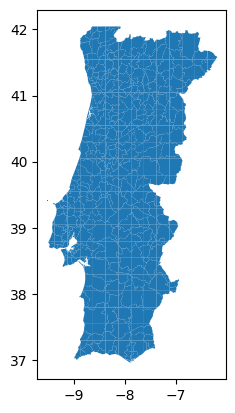

In [30]:
#reduce the polygons to just portugal (intersection of era5 and districts)
results_merge_poly = gpd.overlay(mun_gdf,poly_era5, how='intersection')
#obtain area contribution of each polygon
results_merge_poly['area'] =results_merge_poly.apply(lambda row: row.geometry.area,axis=1)

results_merge_poly.plot()

#### Plotting NUTS2 Intersection

<Axes: >

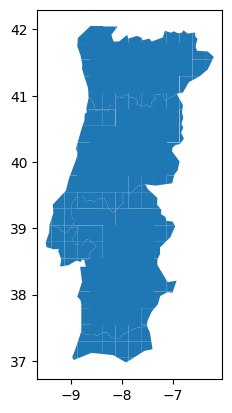

In [32]:
#reduce the polygons to just portugal (intersection of era5 and districts)
results_merge_poly_nuts2 = gpd.overlay(nuts_gdf_mainland,poly_era5, how='intersection')
#obtain area contribution of each polygon
results_merge_poly_nuts2['area'] =results_merge_poly_nuts2.apply(lambda row: row.geometry.area,axis=1)
results_merge_poly_nuts2.plot()

## Debugging For the NUTS!
- Lets try some assert statements to check if we are procceeding correctly 
- If the code below runs with no output, then we are correct!
- If not, we will get an `AssertionError`

In [83]:
# assert '1990' in merged_std_gdf_q.reset_index()['time'].unique()
# assert '1990' in historical_deviations_gdf_q.reset_index()['time'].unique()

## Obtain Polygons to be Joined On
- Here we obtain the era5 polygon grids that fall within portugal so that we can select districts, maintian rows and multindex

In [33]:
dist_poly_to_be_join = gpd.overlay(districts_gdf,poly_era5, how='intersection')

In [34]:
dist_poly_to_be_join_nuts = gpd.overlay(nuts_gdf_mainland,poly_era5, how='intersection')

### Merge With STD Data
- Create area columns
- Rename multindex

In [35]:
std_portugal_era5_test = gpd.sjoin(dist_poly_to_be_join,merged_std_gdf, how='inner', predicate='within')
std_portugal_era5_test['area'] =std_portugal_era5_test.apply(lambda row: row.geometry.area,axis=1)
std_portugal_era5_test.set_index(['index_right0',	'index_right1','index_right2'], inplace = True)
std_portugal_era5_test.index = std_portugal_era5_test.index.rename(['longitude','latitude', 'time'])


In [36]:
std_portugal_era5_test_q = gpd.sjoin(dist_poly_to_be_join,merged_std_gdf_q, how='inner', predicate='within')
std_portugal_era5_test_q['area'] =std_portugal_era5_test_q.apply(lambda row: row.geometry.area,axis=1)
std_portugal_era5_test_q.set_index(['index_right0',	'index_right1','index_right2'], inplace = True)
std_portugal_era5_test_q.index = std_portugal_era5_test_q.index.rename(['longitude','latitude', 'time'])


#### NUTS2

In [37]:
std_portugal_era5_test_q_nuts = gpd.sjoin(dist_poly_to_be_join_nuts,merged_std_gdf_q, how='inner', predicate='within')
std_portugal_era5_test_q_nuts['area'] =std_portugal_era5_test_q_nuts.apply(lambda row: row.geometry.area,axis=1)
std_portugal_era5_test_q_nuts.set_index(['index_right0',	'index_right1','index_right2'], inplace = True)
std_portugal_era5_test_q_nuts.index = std_portugal_era5_test_q_nuts.index.rename(['longitude','latitude', 'time'])

In [38]:
std_portugal_era5_test_q_nuts.head()

NUTS_ID  LEVL_CODE CNTR_CODE  \
longitude latitude  time                                  
-9.5      39.169998 1990Q1    PT16          2        PT   
                    1990Q1    PT17          2        PT   
                    1990Q2    PT16          2        PT   
                    1990Q2    PT17          2        PT   
                    1990Q3    PT16          2        PT   

                                               NAME_LATN  \
longitude latitude  time                                   
-9.5      39.169998 1990Q1                   Centro (PT)   
                    1990Q1  Área Metropolitana de Lisboa   
                    1990Q2                   Centro (PT)   
                    1990Q2  Área Metropolitana de Lisboa   
                    1990Q3                   Centro (PT)   

                                               NUTS_NAME  MOUNT_TYPE  \
longitude latitude  time                                               
-9.5      39.169998 1990Q1                   Centro (PT)         0.0   
                    1990Q1  Área Metropolitana de Lisboa         0.0   
                    1990Q2                   Centro (PT)         0.0   
                    1990Q2  Área Metropolitana de Lisboa         0.0   
                    1990Q3                   Centro (PT)         0.0   

                            URBN_TYPE  COAST_TYPE   FID  \
longitude latitude  time                                  
-9.5      39.169998 1990Q1          0           0  PT16   
                    1990Q1          0           0  PT17   
                    1990Q2          0           0  PT16   
                    1990Q2          0           0  PT17   
                    1990Q3          0           0  PT16   

                                                                     geometry  \
longitude latitude  time                                                        
-9.5      39.169998 1990Q1  POLYGON ((-9.41645 39.05470, -9.37500 39.15134...   
                    1990Q1  POLYGON ((-9.41645 39.05470, -9.37500 39.04502...   
                    1990Q2  POLYGON ((-9.41645 39.05470, -9.37500 39.15134...   
                    1990Q2  POLYGON ((-9.41645 39.05470, -9.37500 39.04502...   
                    1990Q3  POLYGON ((-9.41645 39.05470, -9.37500 39.15134...   

                                 t2m         msl      stl2            sp  \
longitude latitude  time                                                   
-9.5      39.169998 1990Q1  1.113719  556.247131  0.255241  55487.574219   
                    1990Q1  1.113719  556.247131  0.255241  55487.574219   
                    1990Q2  0.683981  445.185822  0.372486  44395.652344   
                    1990Q2  0.683981  445.185822  0.372486  44395.652344   
                    1990Q3  0.717498  236.852676  0.451849  23592.367188   

                                  tp   tp_1000      area  
longitude latitude  time                                  
-9.5      39.169998 1990Q1  0.000166  0.165594  0.002204  
                    1990Q1  0.000166  0.165594  0.000204  
                    1990Q2  0.000055  0.055216  0.002204  
                    1990Q2  0.000055  0.055216  0.000204  
                    1990Q3  0.000018  0.018433  0.002204

### Merge With Historical Deviation Data
- Create area columns

In [39]:
hist_dev_portugal_era5_test = gpd.sjoin(dist_poly_to_be_join,historical_deviations_gdf, how='inner', predicate='within')
hist_dev_portugal_era5_test['area'] =hist_dev_portugal_era5_test.apply(lambda row: row.geometry.area,axis=1)
hist_dev_portugal_era5_test.set_index(['index_right0',	'index_right1','index_right2'], inplace = True)
hist_dev_portugal_era5_test.index = hist_dev_portugal_era5_test.index.rename(['longitude','latitude', 'time'])

In [40]:
hist_dev_portugal_era5_test_q = gpd.sjoin(dist_poly_to_be_join,historical_deviations_gdf_q, how='inner', predicate='within')
hist_dev_portugal_era5_test_q['area'] =hist_dev_portugal_era5_test_q.apply(lambda row: row.geometry.area,axis=1)
hist_dev_portugal_era5_test_q.set_index(['index_right0',	'index_right1','index_right2'], inplace = True)
hist_dev_portugal_era5_test_q.index = hist_dev_portugal_era5_test_q.index.rename(['longitude','latitude', 'time'])

In [41]:
hist_dev_portugal_era5_test_q_nuts = gpd.sjoin(dist_poly_to_be_join_nuts,historical_deviations_gdf_q, how='inner', predicate='within')
hist_dev_portugal_era5_test_q_nuts['area'] =hist_dev_portugal_era5_test_q_nuts.apply(lambda row: row.geometry.area,axis=1)
hist_dev_portugal_era5_test_q_nuts.set_index(['index_right0',	'index_right1','index_right2'], inplace = True)
hist_dev_portugal_era5_test_q_nuts.index = hist_dev_portugal_era5_test_q_nuts.index.rename(['longitude','latitude', 'time'])

## Calculate Weighted Value for Each Climate Variable, For Each Group (District)

### Standard Deviations

In [42]:
# Function to calculate the weighted value for a given climate variable
def calculate_weighted_value(group):
    group['area'] = group.apply(lambda row: row.geometry.area, axis=1)
    weighted_values = {}
    #weighted_values = {'geometry': group['geometry']}  # Include the 'geometry' column
    for variable in ['t2m', 'msl', 'stl2', 'sp', 'tp', 'tp_1000']:
        if f'{variable}_wtd' not in weighted_values:
            weighted_values[f'{variable}_wtd'] = 0
        group[f'{variable}_wtd'] = group[variable] * (group['area'] / group['area'].sum())
        weighted_values[f'{variable}_wtd'] += group[f'{variable}_wtd'].sum()
    return pd.Series(weighted_values)

# Apply the function to each district_id and each point in time
weighted_std_districts = std_portugal_era5_test.groupby(['district_id', 'time']).apply(calculate_weighted_value)#.reset_index()
weighted_std_districts_q = std_portugal_era5_test_q.groupby(['district_id', 'time']).apply(calculate_weighted_value)#.reset_index()


In [43]:
test_plot_weighted = weighted_std_districts.loc[pd.IndexSlice[:, '2020-06-01'], :]
test_plot_weighted = gpd.GeoDataFrame(pd.merge(test_plot_weighted, districts_gdf,on = 'district_id'))
test_plot_weighted

,district_id,t2m_wtd,msl_wtd,stl2_wtd,sp_wtd,tp_wtd,tp_1000_wtd,NAME_1,geometry
0,PT.AV.AG,2.192971,394.563247,1.652334,38530.054087,0.000113,0.113036,Aveiro,"MULTIPOLYGON (((-8.61794 40.48365, -8.62001 40..."
1,PT.BA.AF,3.509481,428.190935,2.599627,40494.179305,0.000054,0.053854,Bragança,"POLYGON ((-6.99479 41.03320, -6.99502 41.03391..."
2,PT.BE.AJ,3.033153,334.858030,2.223416,32671.924263,0.000032,0.032224,Beja,"MULTIPOLYGON (((-7.89185 37.43457, -7.89208 37..."
3,PT.BR.AM,2.545182,416.585022,1.778494,40054.760462,0.000152,0.151822,Braga,"POLYGON ((-8.22311 41.40870, -8.22307 41.40870..."
4,PT.CB.BE,3.490741,366.215401,2.535815,35239.228514,0.000027,0.027255,Castelo Branco,"POLYGON ((-7.51790 39.66582, -7.52089 39.66605..."
5,PT.CO.AR,2.359477,380.391988,1.743315,37064.673108,0.000062,0.061709,Coimbra,"POLYGON ((-8.42796 39.99760, -8.42827 39.99777..."
6,PT.EV.EV,3.235549,343.701036,2.403102,33472.798537,0.000022,0.021640,Évora,"POLYGON ((-7.45825 38.22493, -7.45934 38.22272..."
7,PT.FA.AB,2.353415,323.481211,1.680275,31720.546689,0.000026,0.026117,Faro,"MULTIPOLYGON (((-8.91609 37.01483, -8.91606 37..."
8,PT.GU.AB,3.462125,396.298847,2.483849,37574.603644,0.000042,0.041503,Guarda,"MULTIPOLYGON (((-7.61309 40.31925, -7.61314 40..."
9,PT.LE.OB,1.621503,371.671180,1.264407,36583.919297,0.000036,0.036225,Leiria,"MULTIPOLYGON (((-9.08485 39.29554, -9.08479 39..."


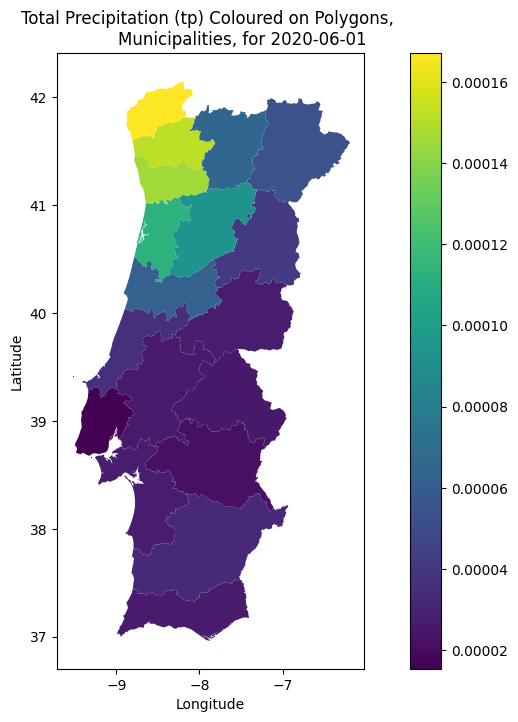

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))

test_plot_weighted.plot(column = 'tp_wtd', kind = 'geo', cmap='viridis', legend=True, ax=ax)
# Add colorbar
#cbar = plt.colorbar(ax.get_children()[1], ax=ax, label='Total Precipitation (tp)')

# Add title and labels
ax.set_title('''Total Precipitation (tp) Coloured on Polygons, 
            Municipalities, for 2020-06-01''')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()


### Historical Deviations

In [45]:
# Assuming hist_dev_portugal_era5_test is your DataFrame
# Calculate the area for each geometry 
hist_dev_portugal_era5_test_c = hist_dev_portugal_era5_test.copy()
hist_dev_portugal_era5_test_c['area'] = hist_dev_portugal_era5_test_c['geometry'].area

# Pre-calculate the sum of areas for each group
area_sum_df = hist_dev_portugal_era5_test_c.groupby(['district_id', 'time'])['area'].sum().reset_index()
area_sum_df.rename(columns={'area': 'total_area'}, inplace=True)

# Merge the total area back into the original DataFrame
hist_dev_portugal_era5_test_c = hist_dev_portugal_era5_test_c.merge(area_sum_df, on=['district_id', 'time'])

# List of variables to process
variables = ['t2m', 'msl', 'stl2', 'sp', 'tp', 'tp_1000']

# Calculate the weighted values directly
for variable in variables:
    weighted_col_name = f'{variable}_wtd'
    hist_dev_portugal_era5_test_c[weighted_col_name] = hist_dev_portugal_era5_test_c[variable] * (hist_dev_portugal_era5_test_c['area'] / hist_dev_portugal_era5_test_c['total_area'])

# Group by and sum the weighted values
weighted_hist_dev_districts = hist_dev_portugal_era5_test_c.groupby(['district_id', 'time'])[ [f'{var}_wtd' for var in variables] ].sum()#.reset_index()


/var/folders/6c/vby383sn3xlg0j_c253f0sf40000gn/T/ipykernel_62298/3209536818.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hist_dev_portugal_era5_test_c['area'] = hist_dev_portugal_era5_test_c['geometry'].area


#### Quarterly Data

In [46]:
# Assuming hist_dev_portugal_era5_test is your DataFrame
# Calculate the area for each geometry 
hist_dev_portugal_era5_test_cq = hist_dev_portugal_era5_test_q.copy()
hist_dev_portugal_era5_test_cq['area'] = hist_dev_portugal_era5_test_cq['geometry'].area

# Pre-calculate the sum of areas for each group
area_sum_df_q = hist_dev_portugal_era5_test_cq.groupby(['district_id', 'time'])['area'].sum().reset_index()
area_sum_df_q.rename(columns={'area': 'total_area'}, inplace=True)

# Merge the total area back into the original DataFrame
hist_dev_portugal_era5_test_cq = hist_dev_portugal_era5_test_cq.merge(area_sum_df_q, on=['district_id', 'time'])

# List of variables to process
variables = ['t2m', 'msl', 'stl2', 'sp', 'tp', 'tp_1000']

# Calculate the weighted values directly
for variable in variables:
    weighted_col_name = f'{variable}_wtd'
    hist_dev_portugal_era5_test_cq[weighted_col_name] = hist_dev_portugal_era5_test_cq[variable] * (hist_dev_portugal_era5_test_cq['area'] / hist_dev_portugal_era5_test_cq['total_area'])

# Group by and sum the weighted values
weighted_hist_dev_districts_q = hist_dev_portugal_era5_test_cq.groupby(['district_id', 'time'])[ [f'{var}_wtd' for var in variables] ].sum()#.reset_index()


/var/folders/6c/vby383sn3xlg0j_c253f0sf40000gn/T/ipykernel_62298/1669435232.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hist_dev_portugal_era5_test_cq['area'] = hist_dev_portugal_era5_test_cq['geometry'].area


In [47]:
test_plot_weighted_hist = weighted_hist_dev_districts.loc[pd.IndexSlice[:, '2022-06-01'], :]
test_plot_weighted_hist = gpd.GeoDataFrame(pd.merge(test_plot_weighted_hist, districts_gdf,on = 'district_id'))
test_plot_weighted_hist

,district_id,t2m_wtd,msl_wtd,stl2_wtd,sp_wtd,tp_wtd,tp_1000_wtd,NAME_1,geometry
0,PT.AV.AG,4.590686,-83.627377,5.344686,-54.039630,-0.001645,-1.644787,Aveiro,"MULTIPOLYGON (((-8.61794 40.48365, -8.62001 40..."
1,PT.BA.AF,7.738239,-171.992833,8.279223,-37.539214,-0.001031,-1.031168,Bragança,"POLYGON ((-6.99479 41.03320, -6.99502 41.03391..."
2,PT.BE.AJ,5.779064,-113.516623,6.621223,-87.059759,-0.001220,-1.219904,Beja,"MULTIPOLYGON (((-7.89185 37.43457, -7.89208 37..."
3,PT.BR.AM,4.725427,-80.809637,5.114371,-27.602034,-0.001423,-1.422627,Braga,"POLYGON ((-8.22311 41.40870, -8.22307 41.40870..."
4,PT.CB.BE,6.910554,-147.153827,7.617351,-71.399583,-0.001748,-1.747998,Castelo Branco,"POLYGON ((-7.51790 39.66582, -7.52089 39.66605..."
5,PT.CO.AR,5.068597,-96.103372,6.013251,-56.395052,-0.002012,-2.011849,Coimbra,"POLYGON ((-8.42796 39.99760, -8.42827 39.99777..."
6,PT.EV.EV,6.269893,-125.679572,7.005284,-92.513221,-0.001368,-1.368110,Évora,"POLYGON ((-7.45825 38.22493, -7.45934 38.22272..."
7,PT.FA.AB,4.570280,-100.761508,5.288433,-81.254220,-0.001242,-1.241605,Faro,"MULTIPOLYGON (((-8.91609 37.01483, -8.91606 37..."
8,PT.GU.AB,7.218345,-154.218621,7.886757,-31.608156,-0.001253,-1.252532,Guarda,"MULTIPOLYGON (((-7.61309 40.31925, -7.61314 40..."
9,PT.LE.OB,4.174494,-82.781436,5.264952,-63.887568,-0.001588,-1.587593,Leiria,"MULTIPOLYGON (((-9.08485 39.29554, -9.08479 39..."


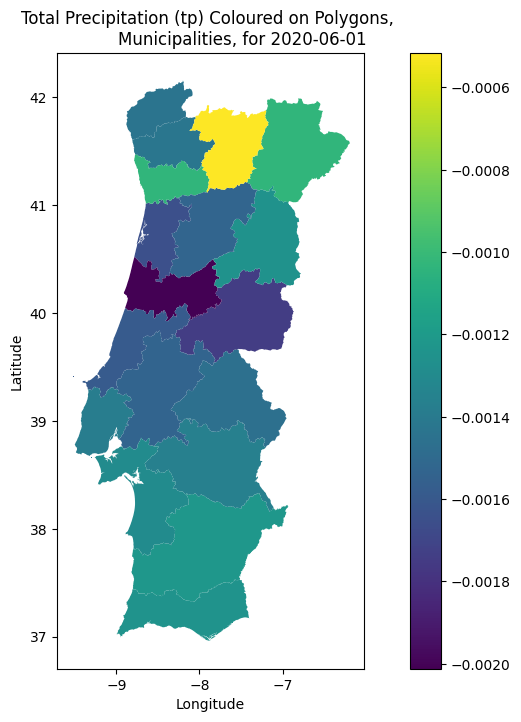

In [48]:
fig, ax = plt.subplots(figsize=(12, 8))
test_plot_weighted_hist.plot(column = 'tp_wtd', kind = 'geo', cmap='viridis', legend=True, ax=ax)
# Add colorbar
#cbar = plt.colorbar(ax.get_children()[1], ax=ax, label='Total Precipitation (tp)')

# Add title and labels
ax.set_title('''Total Precipitation (tp) Coloured on Polygons, 
            Municipalities, for 2020-06-01''')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

# Merging Municipalities and Era5

## Obtain Polygons to be Joined On
- Here we obtain the era5 polygon grids that fall within portugal so that we can select municipalities, maintian rows and multindex

In [49]:
mun_poly_to_be_join = gpd.overlay(municipalities_mainland,poly_era5, how='intersection')

### Merge With STD Data
- Create area columns
- Rename multindex

In [50]:
std_portugal_era5_mun = gpd.sjoin(mun_poly_to_be_join,merged_std_gdf, how='inner', predicate='within')
std_portugal_era5_mun['area'] =std_portugal_era5_mun.apply(lambda row: row.geometry.area,axis=1)
std_portugal_era5_mun.set_index(['index_right0',	'index_right1','index_right2'], inplace = True)
std_portugal_era5_mun.index = std_portugal_era5_mun.index.rename(['longitude','latitude', 'time'])


#### Quarterly data

In [51]:
std_portugal_era5_mun_q = gpd.sjoin(mun_poly_to_be_join,merged_std_gdf_q, how='inner', predicate='within')
std_portugal_era5_mun_q['area'] =std_portugal_era5_mun_q.apply(lambda row: row.geometry.area,axis=1)
std_portugal_era5_mun_q.set_index(['index_right0',	'index_right1','index_right2'], inplace = True)
std_portugal_era5_mun_q.index = std_portugal_era5_mun_q.index.rename(['longitude','latitude', 'time'])

### Merge With Historical Deviation Data
- Create area columns

In [52]:
hist_dev_portugal_era5_mun = gpd.sjoin(mun_poly_to_be_join,historical_deviations_gdf, how='inner', predicate='within')
hist_dev_portugal_era5_mun['area'] =hist_dev_portugal_era5_mun.apply(lambda row: row.geometry.area,axis=1)
hist_dev_portugal_era5_mun.set_index(['index_right0',	'index_right1','index_right2'], inplace = True)
hist_dev_portugal_era5_mun.index = hist_dev_portugal_era5_mun.index.rename(['longitude','latitude', 'time'])

In [53]:
hist_dev_portugal_era5_mun_q = gpd.sjoin(mun_poly_to_be_join,historical_deviations_gdf_q, how='inner', predicate='within')
hist_dev_portugal_era5_mun_q['area'] =hist_dev_portugal_era5_mun_q.apply(lambda row: row.geometry.area,axis=1)
hist_dev_portugal_era5_mun_q.set_index(['index_right0',	'index_right1','index_right2'], inplace = True)
hist_dev_portugal_era5_mun_q.index = hist_dev_portugal_era5_mun_q.index.rename(['longitude','latitude', 'time'])

## Calculate Weighted Value for Each Climate Variable, For Each Group (Municipality)

### Standard Deviations

In [54]:
# Assuming hist_dev_portugal_era5_test is your DataFrame
# Calculate the area for each geometry 
std_portugal_era5_mun_c = std_portugal_era5_mun.copy()
std_portugal_era5_mun_c['area'] = std_portugal_era5_mun_c['geometry'].area

# Pre-calculate the sum of areas for each group
area_sum_df_mun = std_portugal_era5_mun_c.groupby(['district_id', 'time'])['area'].sum().reset_index()
area_sum_df_mun.rename(columns={'area': 'total_area'}, inplace=True)

# Merge the total area back into the original DataFrame
std_portugal_era5_mun_c = std_portugal_era5_mun_c.merge(area_sum_df_mun, on=['district_id', 'time'])

# List of variables to process
variables_std = ['t2m', 'msl', 'stl2', 'sp', 'tp', 'tp_1000']

# Calculate the weighted values directly
for variable in variables_std:
    weighted_col_name = f'{variable}_wtd'
    std_portugal_era5_mun_c[weighted_col_name] = std_portugal_era5_mun_c[variable] * (std_portugal_era5_mun_c['area'] / std_portugal_era5_mun_c['total_area'])

# Group by and sum the weighted values
weighted_std_mun = std_portugal_era5_mun_c.groupby(['district_id', 'time'])[ [f'{var}_wtd' for var in variables_std] ].sum()#.reset_index()


/var/folders/6c/vby383sn3xlg0j_c253f0sf40000gn/T/ipykernel_62298/2673789041.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  std_portugal_era5_mun_c['area'] = std_portugal_era5_mun_c['geometry'].area


In [55]:
# Assuming hist_dev_portugal_era5_test is your DataFrame
# Calculate the area for each geometry 
std_portugal_era5_mun_c_q = std_portugal_era5_mun_q.copy()
std_portugal_era5_mun_c_q['area'] = std_portugal_era5_mun_c_q['geometry'].area

# Pre-calculate the sum of areas for each group
area_sum_df_mun_q = std_portugal_era5_mun_c_q.groupby(['district_id', 'time'])['area'].sum().reset_index()
area_sum_df_mun_q.rename(columns={'area': 'total_area'}, inplace=True)

# Merge the total area back into the original DataFrame
std_portugal_era5_mun_c_q = std_portugal_era5_mun_c_q.merge(area_sum_df_mun_q, on=['district_id', 'time'])

# List of variables to process
variables_std = ['t2m', 'msl', 'stl2', 'sp', 'tp', 'tp_1000']

# Calculate the weighted values directly
for variable in variables_std:
    weighted_col_name = f'{variable}_wtd'
    std_portugal_era5_mun_c_q[weighted_col_name] = std_portugal_era5_mun_c_q[variable] * (std_portugal_era5_mun_c_q['area'] / std_portugal_era5_mun_c_q['total_area'])

# Group by and sum the weighted values
weighted_std_mun_q = std_portugal_era5_mun_c_q.groupby(['district_id', 'time'])[ [f'{var}_wtd' for var in variables_std] ].sum()#.reset_index()


/var/folders/6c/vby383sn3xlg0j_c253f0sf40000gn/T/ipykernel_62298/2303410927.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  std_portugal_era5_mun_c_q['area'] = std_portugal_era5_mun_c_q['geometry'].area


In [56]:
test_plot_weighted_mun_std= weighted_std_mun_q.loc[pd.IndexSlice[:, '2018Q1', :]]
test_plot_weighted_mun_std = gpd.GeoDataFrame(pd.merge(test_plot_weighted_mun_std, municipalities_mainland,on = 'district_id'))
test_plot_weighted_mun_std

,district_id,t2m_wtd,msl_wtd,stl2_wtd,sp_wtd,tp_wtd,tp_1000_wtd,NAME_1,geometry
0,PT.AV.AG,2.178121,914.785232,1.251422,89162.391857,0.000365,0.365129,Aveiro,"POLYGON ((-8.37635 40.69291, -8.37624 40.69271..."
1,PT.AV.AL,2.110151,919.442498,1.227468,90035.074921,0.000342,0.341768,Aveiro,"POLYGON ((-8.45033 40.77946, -8.44866 40.77938..."
2,PT.AV.AN,2.133365,912.499309,1.254321,89688.675886,0.000315,0.315276,Aveiro,"POLYGON ((-8.33899 40.51221, -8.33900 40.51210..."
3,PT.AV.AR,2.293317,916.864139,1.302587,87995.669798,0.000421,0.421055,Aveiro,"POLYGON ((-8.22175 41.01548, -8.22141 41.01532..."
4,PT.AV.AV,1.945500,922.818908,1.059146,91001.981818,0.000319,0.318685,Aveiro,"MULTIPOLYGON (((-8.68958 40.63792, -8.68958 40..."
...,...,...,...,...,...,...,...,...,...
273,PT.VR.SA,2.335237,894.452464,1.348960,85041.660671,0.000233,0.232684,Vila Real,"POLYGON ((-7.61956 41.40142, -7.61071 41.39109..."
274,PT.VR.SM,2.267046,900.765387,1.335123,85527.747344,0.000276,0.275645,Vila Real,"POLYGON ((-7.75235 41.27084, -7.75195 41.27070..."
275,PT.VR.VA,2.363861,892.091576,1.330762,85038.664382,0.000200,0.200464,Vila Real,"POLYGON ((-7.18860 41.78113, -7.18862 41.78086..."
276,PT.VR.VP,2.343951,899.152299,1.313245,85126.407019,0.000267,0.266963,Vila Real,"POLYGON ((-7.61708 41.63699, -7.61663 41.63675..."


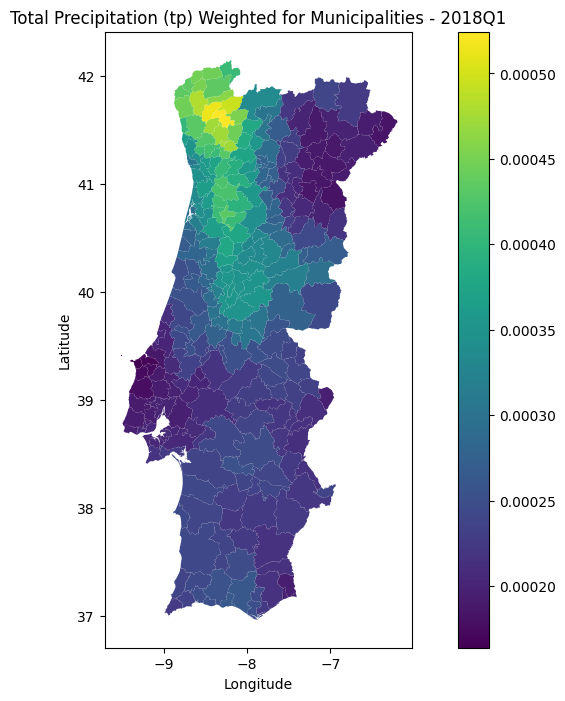

In [57]:
fig, ax = plt.subplots(figsize=(12, 8))
test_plot_weighted_mun_std.plot(column = 'tp_wtd', kind = 'geo', cmap='viridis', legend=True, ax=ax)
# Add colorbar
#cbar = plt.colorbar(ax.get_children()[1], ax=ax, label='Total Precipitation (tp)')

# Add title and labels
ax.set_title('''Total Precipitation (tp) Weighted for Municipalities - 2018Q1''')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

### Historical Deviations

In [58]:
# Assuming hist_dev_portugal_era5_test is your DataFrame
# Calculate the area for each geometry 
hist_dev_portugal_era5_mun_c = hist_dev_portugal_era5_mun.copy()
hist_dev_portugal_era5_mun_c['area'] = hist_dev_portugal_era5_mun_c['geometry'].area

# Pre-calculate the sum of areas for each group
area_sum_df_mun = hist_dev_portugal_era5_mun_c.groupby(['district_id', 'time'])['area'].sum().reset_index()
area_sum_df_mun.rename(columns={'area': 'total_area'}, inplace=True)

# Merge the total area back into the original DataFrame
hist_dev_portugal_era5_mun_c = hist_dev_portugal_era5_mun_c.merge(area_sum_df_mun, on=['district_id', 'time'])

# List of variables to process
variables = ['t2m', 'msl', 'stl2', 'sp', 'tp', 'tp_1000']

# Calculate the weighted values directly
for variable in variables:
    weighted_col_name = f'{variable}_wtd'
    hist_dev_portugal_era5_mun_c[weighted_col_name] = hist_dev_portugal_era5_mun_c[variable] * (hist_dev_portugal_era5_mun_c['area'] / hist_dev_portugal_era5_mun_c['total_area'])

# Group by and sum the weighted values
weighted_hist_dev_mun = hist_dev_portugal_era5_mun_c.groupby(['district_id', 'time'])[ [f'{var}_wtd' for var in variables] ].sum()#.reset_index()

/var/folders/6c/vby383sn3xlg0j_c253f0sf40000gn/T/ipykernel_62298/3427269287.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hist_dev_portugal_era5_mun_c['area'] = hist_dev_portugal_era5_mun_c['geometry'].area


In [59]:
# Assuming hist_dev_portugal_era5_test is your DataFrame
# Calculate the area for each geometry 
hist_dev_portugal_era5_mun_c_q = hist_dev_portugal_era5_mun_q.copy()
hist_dev_portugal_era5_mun_c_q['area'] = hist_dev_portugal_era5_mun_c_q['geometry'].area

# Pre-calculate the sum of areas for each group
area_sum_df_mun_q = hist_dev_portugal_era5_mun_c_q.groupby(['district_id', 'time'])['area'].sum().reset_index()
area_sum_df_mun_q.rename(columns={'area': 'total_area'}, inplace=True)

# Merge the total area back into the original DataFrame
hist_dev_portugal_era5_mun_c_q = hist_dev_portugal_era5_mun_c_q.merge(area_sum_df_mun_q, on=['district_id', 'time'])

# List of variables to process
variables = ['t2m', 'msl', 'stl2', 'sp', 'tp', 'tp_1000']

# Calculate the weighted values directly
for variable in variables:
    weighted_col_name = f'{variable}_wtd'
    hist_dev_portugal_era5_mun_c_q[weighted_col_name] = hist_dev_portugal_era5_mun_c_q[variable] * (hist_dev_portugal_era5_mun_c_q['area'] / hist_dev_portugal_era5_mun_c_q['total_area'])

# Group by and sum the weighted values
weighted_hist_dev_mun_q = hist_dev_portugal_era5_mun_c_q.groupby(['district_id', 'time'])[ [f'{var}_wtd' for var in variables] ].sum()#.reset_index()

/var/folders/6c/vby383sn3xlg0j_c253f0sf40000gn/T/ipykernel_62298/1046848683.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hist_dev_portugal_era5_mun_c_q['area'] = hist_dev_portugal_era5_mun_c_q['geometry'].area


In [60]:
test_plot_weighted_hist_mun = weighted_hist_dev_mun_q.loc[pd.IndexSlice[:, '2017Q3'], :]
test_plot_weighted_hist_mun = gpd.GeoDataFrame(pd.merge(test_plot_weighted_hist_mun, municipalities_mainland,on = 'district_id'))
test_plot_weighted_hist_mun

,district_id,t2m_wtd,msl_wtd,stl2_wtd,sp_wtd,tp_wtd,tp_1000_wtd,NAME_1,geometry
0,PT.AV.AG,6.058399,82.612864,7.783835,120.983437,-0.003450,-3.449774,Aveiro,"POLYGON ((-8.37635 40.69291, -8.37624 40.69271..."
1,PT.AV.AL,5.724036,91.906520,7.485661,121.954023,-0.003342,-3.342425,Aveiro,"POLYGON ((-8.45033 40.77946, -8.44866 40.77938..."
2,PT.AV.AN,5.914270,75.273790,7.696047,99.632916,-0.002930,-2.929772,Aveiro,"POLYGON ((-8.33899 40.51221, -8.33900 40.51210..."
3,PT.AV.AR,6.380548,92.852601,7.855995,157.623983,-0.003914,-3.914190,Aveiro,"POLYGON ((-8.22175 41.01548, -8.22141 41.01532..."
4,PT.AV.AV,5.182408,96.798359,6.600788,116.530013,-0.003153,-3.152918,Aveiro,"MULTIPOLYGON (((-8.68958 40.63792, -8.68958 40..."
...,...,...,...,...,...,...,...,...,...
273,PT.VR.SA,7.445748,48.086370,8.939079,163.464407,-0.001884,-1.884153,Vila Real,"POLYGON ((-7.61956 41.40142, -7.61071 41.39109..."
274,PT.VR.SM,7.121002,67.087143,8.531126,175.754429,-0.002243,-2.243113,Vila Real,"POLYGON ((-7.75235 41.27084, -7.75195 41.27070..."
275,PT.VR.VA,7.917659,39.016265,9.436442,155.902656,-0.001761,-1.760668,Vila Real,"POLYGON ((-7.18860 41.78113, -7.18862 41.78086..."
276,PT.VR.VP,7.381593,64.008273,8.847777,187.105542,-0.002338,-2.337549,Vila Real,"POLYGON ((-7.61708 41.63699, -7.61663 41.63675..."


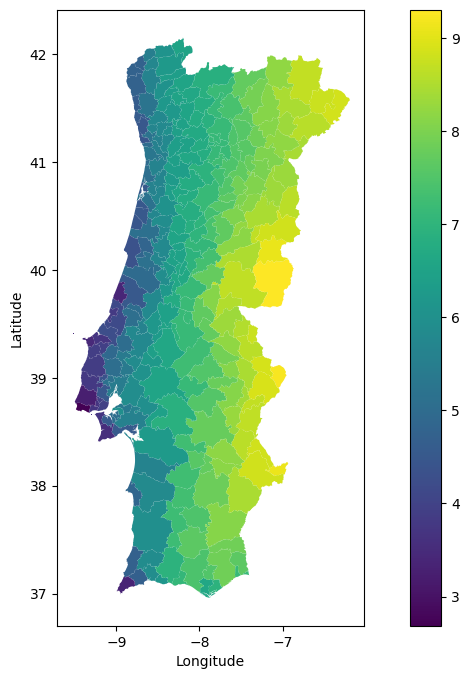

In [61]:
fig, ax = plt.subplots(figsize=(12, 8))
test_plot_weighted_hist_mun.plot(column = 't2m_wtd', kind = 'geo', cmap='viridis', legend=True, ax=ax)
# Add colorbar
#cbar = plt.colorbar(ax.get_children()[1], ax=ax, label='Total Precipitation (tp)')

# Add title and labels
# ax.set_title('''Total Precipitation (tp) Coloured on Polygons, 
#             Municipalities, for 2020-06-01''')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# Show the plot
plt.show()

In [62]:
def create_seasonal(dataframe):
    dataframe['season'] = dataframe.index.get_level_values('time').month.map({
        12: 'winter', 1: 'winter', 2: 'winter',
        3: 'spring', 4: 'spring', 5: 'spring',
        6: 'summer', 7: 'summer', 8: 'summer',
        9: 'autumn', 10: 'autumn', 11: 'autumn'
    })

    # Convert 'season' column to dummy variables
    dataframe = pd.get_dummies(dataframe, columns=['season'], prefix='season')
    return dataframe


In [63]:
weighted_hist_dev_districts = create_seasonal(weighted_hist_dev_districts)
weighted_hist_dev_mun = create_seasonal(weighted_hist_dev_mun)
weighted_std_districts = create_seasonal(weighted_std_districts)
weighted_std_mun = create_seasonal(weighted_std_mun)

## Calculate Weighted Value for Each Climate Variable, For Each Group (NUTS2)

### Standard Deviations

In [64]:
# Assuming hist_dev_portugal_era5_test is your DataFrame
# Calculate the area for each geometry 
std_portugal_era5_test_q_nuts_c = std_portugal_era5_test_q_nuts.copy()
std_portugal_era5_test_q_nuts_c['area'] = std_portugal_era5_test_q_nuts_c['geometry'].area

# Pre-calculate the sum of areas for each group
area_sum_df_mun = std_portugal_era5_test_q_nuts_c.groupby(['NUTS_ID', 'time'])['area'].sum().reset_index()
area_sum_df_mun.rename(columns={'area': 'total_area'}, inplace=True)

# Merge the total area back into the original DataFrame
std_portugal_era5_test_q_nuts_c = std_portugal_era5_test_q_nuts_c.merge(area_sum_df_mun, on=['NUTS_ID', 'time'])

# List of variables to process
variables_std = ['t2m', 'msl', 'stl2', 'sp', 'tp', 'tp_1000']

# Calculate the weighted values directly
for variable in variables_std:
    weighted_col_name = f'{variable}_wtd'
    std_portugal_era5_test_q_nuts_c[weighted_col_name] = std_portugal_era5_test_q_nuts_c[variable] * (std_portugal_era5_test_q_nuts_c['area'] / std_portugal_era5_test_q_nuts_c['total_area'])

# Group by and sum the weighted values
weighted_std_nuts_q = std_portugal_era5_test_q_nuts_c.groupby(['NUTS_ID', 'time'])[ [f'{var}_wtd' for var in variables_std] ].sum()#.reset_index()

/var/folders/6c/vby383sn3xlg0j_c253f0sf40000gn/T/ipykernel_62298/4058774715.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  std_portugal_era5_test_q_nuts_c['area'] = std_portugal_era5_test_q_nuts_c['geometry'].area


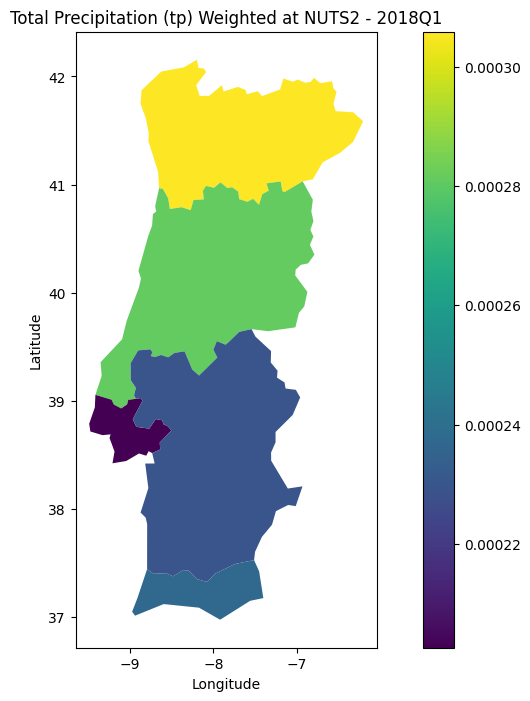

In [65]:
test_plot_weighted_nuts_std= weighted_std_nuts_q.loc[pd.IndexSlice[:, '2018Q1', :]]
test_plot_weighted_nuts_std = gpd.GeoDataFrame(pd.merge(test_plot_weighted_nuts_std, nuts_gdf_mainland,on = 'NUTS_ID'))
fig, ax = plt.subplots(figsize=(12, 8))
test_plot_weighted_nuts_std.plot(column = 'tp_wtd', kind = 'geo', cmap='viridis', legend=True, ax=ax)
# Add colorbar
#cbar = plt.colorbar(ax.get_children()[1], ax=ax, label='Total Precipitation (tp)')

# Add title and labels
ax.set_title('''Total Precipitation (tp) Weighted at NUTS2 - 2018Q1''')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# Show the plot
plt.show()

In [66]:
# Assuming hist_dev_portugal_era5_test is your DataFrame
# Calculate the area for each geometry 
hist_dev_portugal_era5_test_q_nuts_c = hist_dev_portugal_era5_test_q_nuts.copy()
hist_dev_portugal_era5_test_q_nuts_c['area'] = hist_dev_portugal_era5_test_q_nuts_c['geometry'].area

# Pre-calculate the sum of areas for each group
area_sum_df_mun = hist_dev_portugal_era5_test_q_nuts_c.groupby(['NUTS_ID', 'time'])['area'].sum().reset_index()
area_sum_df_mun.rename(columns={'area': 'total_area'}, inplace=True)

# Merge the total area back into the original DataFrame
hist_dev_portugal_era5_test_q_nuts_c = hist_dev_portugal_era5_test_q_nuts_c.merge(area_sum_df_mun, on=['NUTS_ID', 'time'])

# List of variables to process
variables = ['t2m', 'msl', 'stl2', 'sp', 'tp', 'tp_1000']

# Calculate the weighted values directly
for variable in variables:
    weighted_col_name = f'{variable}_wtd'
    hist_dev_portugal_era5_test_q_nuts_c[weighted_col_name] = hist_dev_portugal_era5_test_q_nuts_c[variable] * (hist_dev_portugal_era5_test_q_nuts_c['area'] / hist_dev_portugal_era5_test_q_nuts_c['total_area'])

# Group by and sum the weighted values
weighted_hist_dev_nuts = hist_dev_portugal_era5_test_q_nuts_c.groupby(['NUTS_ID', 'time'])[ [f'{var}_wtd' for var in variables] ].sum()#.reset_index()

/var/folders/6c/vby383sn3xlg0j_c253f0sf40000gn/T/ipykernel_62298/2045034178.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hist_dev_portugal_era5_test_q_nuts_c['area'] = hist_dev_portugal_era5_test_q_nuts_c['geometry'].area


In [68]:
# test_plot_weighted_hist_nuts = weighted_hist_dev_nuts.loc[pd.IndexSlice[:, '2022'], :]
# test_plot_weighted_hist_nuts = gpd.GeoDataFrame(pd.merge(test_plot_weighted_hist_nuts, nuts_gdf_mainland ,on = 'NUTS_ID'))
# fig, ax = plt.subplots(figsize=(12, 8))
# test_plot_weighted_hist_nuts.plot(column = 'tp_wtd', kind = 'geo', cmap='viridis', legend=True, ax=ax)
# # Add colorbar
# #cbar = plt.colorbar(ax.get_children()[1], ax=ax, label='Total Precipitation (tp)')

# # Add title and labels
# ax.set_title('''Total Precipitation (tp) Coloured on Polygons, 
#             Municipalities, for 2020-06-01''')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')

# # Show the plot
# plt.show()

# Convert to NetCDF

In [76]:
weighted_hist_dev_districts_ds = weighted_hist_dev_districts.to_xarray()
weighted_hist_dev_mun_ds = weighted_hist_dev_mun.to_xarray()
weighted_std_districts_ds = weighted_std_districts.to_xarray()
weighted_std_mun_ds = weighted_std_mun.to_xarray()

In [77]:
weighted_hist_dev_districts_ds.to_netcdf(r'../../database/weighted_hist_dev_districts.nc')
weighted_hist_dev_mun_ds.to_netcdf(r'../../database/weighted_hist_dev_mun.nc')
weighted_std_districts_ds.to_netcdf(r'../../database/weighted_std_districts.nc')
weighted_std_mun_ds.to_netcdf(r'../../database/weighted_std_mun.nc')

## Convert To Excel 

In [69]:
#weighted_hd_dist_q_excel = weighted_hist_dev_districts_q.reset_index()
weighted_hd_mun_q_excel = weighted_hist_dev_mun_q.reset_index()
#weighted_std_dist_q_excel = weighted_std_districts_q.reset_index()
weighted_std_mun_q_excel = weighted_std_mun_q.reset_index()

In [74]:
#weighted_hd_dist_q_excel.to_excel(r'../../database/excel/quarterly/weighted_hist_dev_districts.xlsx')
weighted_hd_mun_q_excel.to_excel(r'../datasets/era5/excel/quarterly/weighted_hist_dev_mun.xlsx')
#weighted_std_dist_q_excel.to_excel(r'../../database/excel/quarterly/weighted_std_districts.xlsx')
weighted_std_mun_q_excel.to_excel(r'../datasets/era5/excel/quarterly/weighted_std_mun.xlsx')

### NUTS 2

In [75]:
weighted_std_nuts_q_excel = weighted_std_nuts_q.reset_index()
weighted_hd_nuts_q_excel = weighted_hist_dev_nuts.reset_index()
weighted_std_nuts_q_excel.to_excel(r'../datasets/era5/excel/quarterly/weighted_std_nuts_yearly.xlsx')
weighted_hd_nuts_q_excel.to_excel(r'../datasets/era5/excel/quarterly/weighted_hist_dev_nuts_yearly.xlsx')

##### Test

In [54]:
weighted_hd_nuts_q_excel_test = pd.read_excel(r'../../database/excel/quarterly/weighted_std_nuts_yearly.xlsx')
weighted_std_nuts_q_excel_test = pd.read_excel(r'../../database/excel/quarterly/weighted_hist_dev_nuts_yearly.xlsx')


In [48]:
weighted_std_nuts_q_excel

,NUTS_ID,time,t2m_wtd,msl_wtd,stl2_wtd,sp_wtd,tp_wtd,tp_1000_wtd
0,PT11,1990,2.417456,456.406966,1.553918,438.960388,0.000176,0.176084
1,PT11,1991,2.828188,511.563492,1.939936,489.640988,0.000193,0.192716
2,PT11,1992,2.561851,482.289160,1.706880,465.425577,0.000230,0.229523
3,PT11,1993,2.491658,479.578340,1.673238,461.427654,0.000199,0.198648
4,PT11,1994,2.493087,535.008127,1.640287,512.897135,0.000247,0.247398
...,...,...,...,...,...,...,...,...
160,PT18,2018,2.456188,460.969379,1.709872,452.584194,0.000134,0.133555
161,PT18,2019,2.472290,404.803207,1.715002,397.405815,0.000105,0.104621
162,PT18,2020,2.405134,431.267724,1.708235,425.376266,0.000124,0.124458
163,PT18,2021,2.261551,392.510880,1.627319,385.344336,0.000135,0.134897
